<a href="https://colab.research.google.com/github/Monalika-P/Portuguese-to-English-Translation-/blob/master/Portuguese%20to%20English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Portuguese to English translation
Author - Monalika P

## Importing Dependencies

In [2]:
import numpy as np
import pandas as pd
import re
import math
import re
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

##Loading Dataset

The dataset is available in Tfds

In [3]:
data, metadata = tfds.load('ted_hrlr_translate/pt_to_en',with_info = True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete45KTRP/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete45KTRP/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete45KTRP/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
data

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)>}

In [5]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

## Taking Train and Validation Data

In [6]:
train, val = data['train'], data['validation']

In [7]:
type(train)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [8]:
type(val)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

## Creating a custom subwords tokenizer from the training dataset

In [9]:
count = 0
for a, b in train:
  count += 1
  if count == 10:
    break
  else:
    print("Portugees sentence:",a)
    print("English Corresponding Sentence",b)
    print("--"*60)

Portugees sentence: tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)
English Corresponding Sentence tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)
------------------------------------------------------------------------------------------------------------------------
Portugees sentence: tf.Tensor(b'mas e se estes fatores fossem ativos ?', shape=(), dtype=string)
English Corresponding Sentence tf.Tensor(b'but what if it were active ?', shape=(), dtype=string)
------------------------------------------------------------------------------------------------------------------------
Portugees sentence: tf.Tensor(b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .', shape=(), dtype=string)
English Corresponding Sentence tf.Tensor(b"but they did n't test for curiosity .", shape=(), 

In [10]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train), target_vocab_size = 2**13
)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train), target_vocab_size = 2**13
)

In [11]:
tokenizer_en.save_to_file('tokenizer_en')
tokenizer_pt.save_to_file('tokenizer_pt')

In [12]:
# Loading saved tokenizer
encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file('/content/tokenizer_en')
encoder_pt = tfds.features.text.SubwordTextEncoder.load_from_file('/content/tokenizer_pt')

In [13]:
sample_string = "Portuguese to English translation. "

encoded_string = encoder_en.encode(sample_string)

original_string = encoder_en.decode(encoded_string)

print("Orginal String:",sample_string)
print("Encoded String:",encoded_string)
print("Decoded String:",original_string)

Orginal String: Portuguese to English translation. 
Encoded String: [7911, 1785, 3662, 6939, 104, 5, 7900, 321, 4230, 606, 6512, 302]
Decoded String: Portuguese to English translation. 


In [14]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7911 ----> P
1785 ----> ort
3662 ----> ug
6939 ----> ues
104 ----> e 
5 ----> to 
7900 ----> E
321 ----> ng
4230 ----> lis
606 ----> h 
6512 ----> translation
302 ----> . 


In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

## Add a start and end token to the input and target

In [16]:
print(encoder_pt.vocab_size)
print(encoder_en.vocab_size)

8214
8087


In [17]:
a = [encoder_pt.vocab_size]
b = np.array([2])
print(b[0])
c = a + b[0]
print(c)

2
[8216]


In [18]:
def encode(lang1, lang2):
  lang1 = [encoder_pt.vocab_size] + encoder_pt.encode(lang1.numpy()) + [encoder_pt.vocab_size + 1]

  lang2 = [encoder_en.vocab_size] + encoder_en.encode(lang2.numpy()) + [encoder_en.vocab_size + 1]

  return lang1, lang2

In [19]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

## Dropping long sentences over 40 tokens

In [20]:
MAX_LENGTH = 40

In [21]:
def filter_max_length(x, y, max_length = MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [22]:
train_dataset = train.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [23]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## Positional Encoding

In [24]:
def get_angles(pos, i, d_model):
  angles_rates = 1 / np.power(1000, (2 * (i//2)) / np.float32(d_model))
  return pos * angles_rates

In [25]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [26]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

(1, 50, 512)


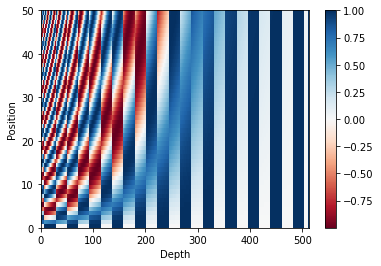

In [27]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking
Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [28]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.

  return seq[:, tf.newaxis, tf.newaxis, :]

In [29]:
xx = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(xx)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [30]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [31]:
xx = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(xx.shape[1])
temp  

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled Dot Product attention

In [32]:
def scaled_dot_product_attention(q, k, v, mask):

  matmul_qk = tf.matmul(q, v, transpose_b = True)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # Applying softmax
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)

  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [33]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

## Multi-head attention


In [34]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(units = self.d_model)
    self.wk = tf.keras.layers.Dense(units = self.d_model)
    self.wv = tf.keras.layers.Dense(units = self.d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  
    k = self.wk(k)  
    v = self.wv(v)  

    q = self.split_heads(q, batch_size) 
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)  

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  

    output = self.dense(concat_attention)  
    return output, attention_weights

In [35]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

In [36]:
def  point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  
      tf.keras.layers.Dense(d_model)  
  ])

In [37]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and Decoder

### Encoder Layer

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate = 0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [39]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### Decoder Layer

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  
    
    ffn_output = self.ffn(out2)  
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  
    
    return out3, attn_weights_block1, attn_weights_block2

In [41]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

In [42]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    x = self.embedding(x)  
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  

In [43]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)

(64, 62, 512)


### Decoder


In [44]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [45]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [46]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Transformer

In [54]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask,look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask) 

    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  
    
    return final_output, attention_weights

## Setting Hyperparameters

In [55]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = encoder_pt.vocab_size + 2
target_vocab_size = encoder_en.vocab_size + 2
dropout_rate = 0.1

### Optimizer

In [56]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [57]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

### Loss and Metrics

In [73]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [74]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [75]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [76]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [77]:
def create_masks(inp, tar):
  
  enc_padding_mask = create_padding_mask(inp)
  
  dec_padding_mask = create_padding_mask(inp)
  
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [78]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [79]:
EPOCHS = 20

In [80]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [81]:
from tqdm import tqdm
import time

In [ ]:
for epoch in tqdm(range(EPOCHS)):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))




  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 8.9989 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9435 Accuracy 0.0046
Epoch 1 Batch 100 Loss 8.8478 Accuracy 0.0148
Epoch 1 Batch 150 Loss 8.7426 Accuracy 0.0189
Epoch 1 Batch 200 Loss 8.6156 Accuracy 0.0209
Epoch 1 Batch 250 Loss 8.4625 Accuracy 0.0221
Epoch 1 Batch 300 Loss 8.2887 Accuracy 0.0232
Epoch 1 Batch 350 Loss 8.1036 Accuracy 0.0250
Epoch 1 Batch 400 Loss 7.9247 Accuracy 0.0283
Epoch 1 Batch 450 Loss 7.7620 Accuracy 0.0320
Epoch 1 Batch 500 Loss 7.6183 Accuracy 0.0351
Epoch 1 Batch 550 Loss 7.4858 Accuracy 0.0381
Epoch 1 Batch 600 Loss 7.3630 Accuracy 0.0414
Epoch 1 Batch 650 Loss 7.2461 Accuracy 0.0451
Epoch 1 Batch 700 Loss 7.1317 Accuracy 0.0489




  5%|▌         | 1/20 [14:25<4:34:00, 865.30s/it]

Epoch 1 Loss 7.1274 Accuracy 0.0490
Time taken for 1 epoch: 865.2990398406982 secs

Epoch 2 Batch 0 Loss 5.5091 Accuracy 0.1026
Epoch 2 Batch 50 Loss 5.4945 Accuracy 0.1039
Epoch 2 Batch 100 Loss 5.4182 Accuracy 0.1072
Epoch 2 Batch 150 Loss 5.3643 Accuracy 0.1090
Epoch 2 Batch 200 Loss 5.3210 Accuracy 0.1108
Epoch 2 Batch 250 Loss 5.2738 Accuracy 0.1129
Epoch 2 Batch 300 Loss 5.2376 Accuracy 0.1147
Epoch 2 Batch 350 Loss 5.1990 Accuracy 0.1166
Epoch 2 Batch 400 Loss 5.1627 Accuracy 0.1180
Epoch 2 Batch 450 Loss 5.1307 Accuracy 0.1197
Epoch 2 Batch 500 Loss 5.1004 Accuracy 0.1209
Epoch 2 Batch 550 Loss 5.0705 Accuracy 0.1224
Epoch 2 Batch 600 Loss 5.0444 Accuracy 0.1236
Epoch 2 Batch 650 Loss 5.0182 Accuracy 0.1249
Epoch 2 Batch 700 Loss 4.9941 Accuracy 0.1261




 10%|█         | 2/20 [28:07<4:15:42, 852.36s/it]

Epoch 2 Loss 4.9932 Accuracy 0.1261
Time taken for 1 epoch: 822.1731073856354 secs

Epoch 3 Batch 0 Loss 4.5628 Accuracy 0.1643
Epoch 3 Batch 50 Loss 4.5973 Accuracy 0.1425
Epoch 3 Batch 100 Loss 4.5837 Accuracy 0.1433
Epoch 3 Batch 150 Loss 4.5742 Accuracy 0.1441
Epoch 3 Batch 200 Loss 4.5592 Accuracy 0.1448
Epoch 3 Batch 250 Loss 4.5471 Accuracy 0.1453
Epoch 3 Batch 300 Loss 4.5358 Accuracy 0.1462
Epoch 3 Batch 350 Loss 4.5275 Accuracy 0.1470
Epoch 3 Batch 400 Loss 4.5155 Accuracy 0.1474
Epoch 3 Batch 450 Loss 4.5006 Accuracy 0.1480
Epoch 3 Batch 500 Loss 4.4893 Accuracy 0.1486
Epoch 3 Batch 550 Loss 4.4804 Accuracy 0.1490
Epoch 3 Batch 600 Loss 4.4689 Accuracy 0.1495
Epoch 3 Batch 650 Loss 4.4613 Accuracy 0.1499
Epoch 3 Batch 700 Loss 4.4512 Accuracy 0.1505




 15%|█▌        | 3/20 [41:48<3:58:52, 843.08s/it]

Epoch 3 Loss 4.4506 Accuracy 0.1505
Time taken for 1 epoch: 821.4309628009796 secs

Epoch 4 Batch 0 Loss 3.9891 Accuracy 0.1774
Epoch 4 Batch 50 Loss 4.2104 Accuracy 0.1604
Epoch 4 Batch 100 Loss 4.1954 Accuracy 0.1602
Epoch 4 Batch 150 Loss 4.1941 Accuracy 0.1603
Epoch 4 Batch 200 Loss 4.1911 Accuracy 0.1605
Epoch 4 Batch 250 Loss 4.1856 Accuracy 0.1610
Epoch 4 Batch 300 Loss 4.1814 Accuracy 0.1613
Epoch 4 Batch 350 Loss 4.1676 Accuracy 0.1623
Epoch 4 Batch 400 Loss 4.1587 Accuracy 0.1627
Epoch 4 Batch 450 Loss 4.1486 Accuracy 0.1635
Epoch 4 Batch 500 Loss 4.1382 Accuracy 0.1643
Epoch 4 Batch 550 Loss 4.1287 Accuracy 0.1649
Epoch 4 Batch 600 Loss 4.1219 Accuracy 0.1656
Epoch 4 Batch 650 Loss 4.1121 Accuracy 0.1662
Epoch 4 Batch 700 Loss 4.1017 Accuracy 0.1668




 20%|██        | 4/20 [55:24<3:42:36, 834.80s/it]

Epoch 4 Loss 4.1015 Accuracy 0.1668
Time taken for 1 epoch: 815.4445564746857 secs

Epoch 5 Batch 0 Loss 3.8959 Accuracy 0.1554
Epoch 5 Batch 50 Loss 3.8140 Accuracy 0.1801
Epoch 5 Batch 100 Loss 3.8155 Accuracy 0.1812
Epoch 5 Batch 150 Loss 3.8034 Accuracy 0.1828
Epoch 5 Batch 200 Loss 3.7904 Accuracy 0.1834
Epoch 5 Batch 250 Loss 3.7799 Accuracy 0.1841
Epoch 5 Batch 300 Loss 3.7747 Accuracy 0.1844
Epoch 5 Batch 350 Loss 3.7638 Accuracy 0.1852
Epoch 5 Batch 400 Loss 3.7464 Accuracy 0.1863
Epoch 5 Batch 450 Loss 3.7351 Accuracy 0.1870
Epoch 5 Batch 500 Loss 3.7244 Accuracy 0.1876
Epoch 5 Batch 550 Loss 3.7120 Accuracy 0.1883
Epoch 5 Batch 600 Loss 3.6989 Accuracy 0.1892
Epoch 5 Batch 650 Loss 3.6853 Accuracy 0.1899
Epoch 5 Batch 700 Loss 3.6758 Accuracy 0.1908




 25%|██▌       | 5/20 [1:08:56<3:26:58, 827.91s/it]

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Loss 3.6749 Accuracy 0.1908
Time taken for 1 epoch: 811.8342163562775 secs

Epoch 6 Batch 0 Loss 3.4401 Accuracy 0.1928
Epoch 6 Batch 50 Loss 3.3121 Accuracy 0.2100
Epoch 6 Batch 100 Loss 3.3116 Accuracy 0.2096
Epoch 6 Batch 150 Loss 3.3191 Accuracy 0.2095
Epoch 6 Batch 200 Loss 3.3169 Accuracy 0.2100
Epoch 6 Batch 250 Loss 3.3187 Accuracy 0.2105
Epoch 6 Batch 300 Loss 3.3161 Accuracy 0.2106
Epoch 6 Batch 350 Loss 3.3080 Accuracy 0.2110
Epoch 6 Batch 400 Loss 3.3021 Accuracy 0.2116
Epoch 6 Batch 450 Loss 3.2937 Accuracy 0.2122
Epoch 6 Batch 500 Loss 3.2886 Accuracy 0.2127
Epoch 6 Batch 550 Loss 3.2818 Accuracy 0.2132
Epoch 6 Batch 600 Loss 3.2752 Accuracy 0.2136
Epoch 6 Batch 650 Loss 3.2686 Accuracy 0.2141
Epoch 6 Batch 700 Loss 3.2603 Accuracy 0.2147




 30%|███       | 6/20 [1:22:28<3:12:04, 823.15s/it]

Epoch 6 Loss 3.2598 Accuracy 0.2147
Time taken for 1 epoch: 812.0523462295532 secs

Epoch 7 Batch 0 Loss 2.9904 Accuracy 0.2212
